<a href="https://colab.research.google.com/github/mr-rojit/Fruits_detection/blob/main/FruitsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])


In [4]:
TRAIN_DIR ="/content/drive/MyDrive/data/fruits/train"
VAL_DIR ="/content/drive/MyDrive/data/fruits/test"


train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = ImageFolder(root=VAL_DIR, transform=val_transforms)
len(train_dataset), len(val_dataset)

(2301, 1025)

In [5]:
train_dataset.class_to_idx

{'apple': 0,
 'avocado': 1,
 'banana': 2,
 'cherry': 3,
 'kiwi': 4,
 'mango': 5,
 'orange': 6,
 'pinenapple': 7,
 'strawberries': 8,
 'watermelon': 9}

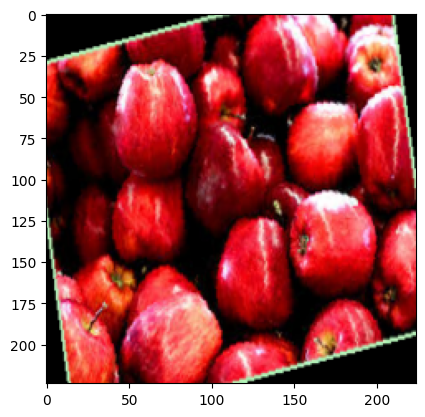

In [6]:
sample_image, sample_label = train_dataset[40]
plt.imshow(sample_image.permute(1,2,0))

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
len(train_loader)

72

In [29]:
class FruitClassifier(nn.Module):

  def __init__(self, num_classes=10):
    super().__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer2 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer3 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer4 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer5 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))


    # fc layer start

    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(7*7*512, 1024),
        nn.ReLU()
    )

    self.fc2 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1024, 128),
        nn.ReLU()
    )

    self.fc3 = nn.Sequential(
        nn.Linear(128, num_classes),
    )


  def forward(self, X):
    out = self.layer1(X)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)

    # Flattening
    out = out.reshape(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out

model = FruitClassifier().to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
        MaxPool2d-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [30]:

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}.")

In [31]:
EPOCHS = 30
model = FruitClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss = []

for i in range(EPOCHS):
  mini_batch_losses = []
  model.train()
  for x,y in train_loader:
    x = x.to(device)
    y = y.to(device)

    pred = model(x)
    optimizer.zero_grad()
    loss = loss_fn(pred, y)
    mini_batch_losses.append(loss.item())

    loss.backward()
    optimizer.step()

  avg_mini_batch_loss = np.mean(mini_batch_losses)
  print(avg_mini_batch_loss)
  train_loss.append(avg_mini_batch_loss)
  save_checkpoint(model, optimizer, i+1, avg_mini_batch_loss)

1.812572095129225
Checkpoint saved at epoch 1.
1.330633744597435
Checkpoint saved at epoch 2.
1.1932186699575849
Checkpoint saved at epoch 3.
1.056009140279558
Checkpoint saved at epoch 4.
1.0116439618998103
Checkpoint saved at epoch 5.
0.9480552300810814
Checkpoint saved at epoch 6.
0.934294280078676
Checkpoint saved at epoch 7.
0.8819482992920611
Checkpoint saved at epoch 8.
0.8330143930183517
Checkpoint saved at epoch 9.
0.7570517361164093
Checkpoint saved at epoch 10.
0.7393278454740843
Checkpoint saved at epoch 11.
0.695882065842549
Checkpoint saved at epoch 12.
0.6923439477880796
Checkpoint saved at epoch 13.
0.6671890947553847
Checkpoint saved at epoch 14.
0.6429093115859561
Checkpoint saved at epoch 15.
0.6119588470707337
Checkpoint saved at epoch 16.
0.5721034742891788
Checkpoint saved at epoch 17.
0.5604927194201283
Checkpoint saved at epoch 18.
0.5553659225503603
Checkpoint saved at epoch 19.
0.5307088061753247
Checkpoint saved at epoch 20.
0.4663904627992047
Checkpoint save

In [32]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model: {accuracy:.2f}%')
    return accuracy

accuracy = evaluate_model(model, val_loader)

Accuracy of the model: 74.34%
